<a href="https://colab.research.google.com/github/islamouda/C4B-Team-Professional/blob/master/Wmain_first_model_web.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')\

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import spacy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional,GRU , concatenate ,Input , Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
from keras.models import Model
import nltk
import csv
import itertools
nltk.download('punkt')
import pandas as pd
from tensorflow.keras.models import Model
import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
maxlen = 50
labels = []
sentences = []
vocabulary_size = 8000
seq_length = 50
seq_length_glove=200
unknown_token = "UNKNOWN_TOKEN"
#0 for unsexual
#1 for sexual


with open(r'/content/drive/MyDrive/Colab Notebooks/nh_h_train.csv', 'r') as f:
    reader = csv.reader(f, skipinitialspace=True)
    data = []
    
    for x in reader:
        data.append((x[0].lower(),int(x[1])))
        
    for d in data:
        labels.append(d[1])
        sentences.append(d[0])

with open(r'/content/drive/MyDrive/Colab Notebooks/nh_h_test.csv','r') as f:
    reader = csv.reader(f, skipinitialspace=True)
    data = []

    for x in reader:
        data.append((x[0].lower(),int(x[1])))
        
    for d in data:
        labels.append(d[1])
        sentences.append(d[0])

# start tokenized for the word 
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))
 
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size - 1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i+1) for i,w in enumerate(index_to_word)])
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

print("\nExample sentence: '%s'" % sentences[0])
print("\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])

example_int = []
for example in tokenized_sentences:
    index = [word_to_index[w] for w in example]
    example_int.append(index)
# end tokenized

labels = np.array(labels)
features =example_int


#x_train, x_val, y_train, y_val = train_test_split( features, labels,test_size=0.1,random_state=0,shuffle=True)
x_train, x_test, y_train, y_test = train_test_split( features, labels, test_size=0.2,random_state=0,shuffle=True)

print(x_train[0],y_train[0])

#vocabulary for both model
vocab_size =vocabulary_size + 1  # Adding 1 because of reserved 0 index
print(vocabulary_size)

#padding
X_Train = pad_sequences(x_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
print(X_Train.shape,y_train.shape)

Found 45953 unique words tokens.

Example sentence: 'my last two starts i threw the ball good pineda said thats what im working to do every start try to keep the ball down and hit the corner making good pitches and getting outs'

Example sentence after Pre-processing: '['my', 'last', 'two', 'starts', 'i', 'threw', 'the', 'ball', 'good', 'pineda', 'said', 'thats', 'what', 'im', 'working', 'to', 'do', 'every', 'start', 'try', 'to', 'keep', 'the', 'ball', 'down', 'and', 'hit', 'the', 'corner', 'making', 'good', 'pitches', 'and', 'getting', 'outs']'
[13, 2096, 98, 89, 52, 8000, 93, 443, 8000, 17, 3, 2276, 98, 4, 2334, 97, 3659, 11, 4150] 0
8000
(19696, 50) (19696,)


In [ ]:
# glove vocter with 200 d

embeddings_index = {}
f = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.200d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


embedding_matrix = np.zeros((len(word_to_index) + 1, seq_length_glove))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [ ]:
from keras.models import Sequential
from keras.layers import  Activation, Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Activation, Dense, Embedding ,Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.models import Model

input_dim = 10
output_dim = 400
embedding_size=400
vocabulary_size=8000+1
op_units=1
inputs = Input(shape=(50,), dtype='float32')

model1 = Sequential()
model1=Embedding(len(word_to_index) + 1, seq_length_glove, weights=[embedding_matrix], trainable=False)(inputs)
model1=GRU(256,return_sequences=True)(model1)
model1=Dense(256, activation="relu")(model1)

model2 = Sequential()
model2=Embedding(vocabulary_size,400)(inputs)
model2=Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True))(model2)
model2=Dense(256,activation="relu")(model2)



merged = concatenate([model1, model2],axis=-1)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(merged)
#mergedo=Dense(1,activation="sigmoid")
model=Model(inputs=inputs,outputs=outputs)

opt = keras.optimizers.Adamax(0.00001)
model.summary()
model.compile(optimizer=opt, loss="binary_crossentropy",metrics=["accuracy"])
mcp_save = ModelCheckpoint(r'/content/first.hdf5', save_best_only=True, monitor='val_loss', mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=20, min_lr=0.00001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(X_Train,y_train,epochs=200,batch_size=64,validation_split=0.25,validation_steps=20, verbose=1,callbacks=[earlyStopping, mcp_save,tensorboard_callback])


loss, accuracy = model.evaluate(X_Train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 50, 200)      1600200     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 50, 400)      3200400     input_11[0][0]                   
__________________________________________________________________________________________________
gru_8 (GRU)                     (None, 50, 256)      351744      embedding_18[0][0]               
____________________________________________________________________________________________

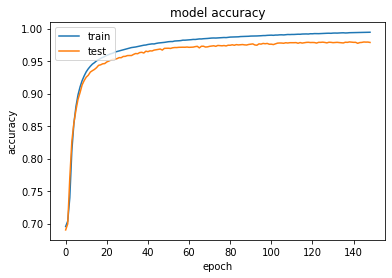

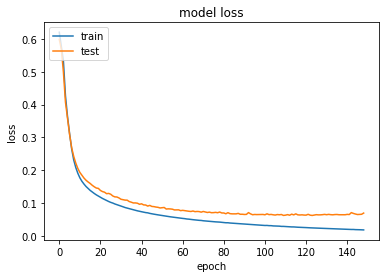

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/first.hdf5')

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

from sklearn.metrics import classification_report
import time
import numpy as np
start_time = time.time()
print(classification_report(y_test,yhat_classes))
print("Time taken to predict the model " + str(time.time() - start_time))




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3354
           1       0.91      0.98      0.94      1570

    accuracy                           0.96      4924
   macro avg       0.95      0.97      0.96      4924
weighted avg       0.97      0.96      0.96      4924

Time taken to predict the model 0.010516166687011719
